# MOwNiT
## Laboratorium 2 - Arytmetyka komputerowa


Kalkulatory IEEE-754:
* https://www.h-schmidt.net/FloatConverter/IEEE754.html

In [2]:
# znak, cecha, mantysa
# uwaga - w Julii tablice indeksujemy od 1
# uwaga: ukryta jedynka nie jest pamiętana
# uwaga: cecha jest pamiętana w kodzie z nadmiarem (tutaj BIAS=127)
decode(x::Float32) = (b=bitstring(x); (b[1], b[2:9], b[10:32]))

decode (generic function with 1 method)

## Trochę teorii o IEEE-754

Liczby zmienno przecinkowe są zapisywane w standardzie jako:

$L = (-1)^{znak} * mantysa * 2^{cecha}$ 

* znak - 0 oznacza liczbę dodatnią, 1 ujemną
* mantysa - wpływa na precyzje
* cecha - wpływa na zakres, składająca się z samych 0 albo 1 ma specjalne znaczenie

| Nazwa     | Liczba bitów | Bity znaku | Bity cechy | Bity mantysy | Bias  | Dokładność (cyfry znaczące) | Uwagi                                 |
|-----------|--------------|------------|------------|--------------|-------|-----------------------------|---------------------------------------|
| half      | 16           | 1          | 5          | 10           | 15    | 4                           |                                       |
| single    | 32           | 1          | 8          | 23           | 127   | 7                           |                                       |
| double    | 64           | 1          | 11         | 52           | 1023  | 16                          |                                       |
| quadruple | 128          | 1          | 15         | 112          | 16383 | 34                          | Wprowadzone w 2008, niezbyt popularne |

### Liczby znormalizowane

Mantysa ma wartość z przedziału [1,2) - pierwszy bit ma zawsze wartość 1, więc nie trzeba go zapisywać (jest on tam "domyślnie")
$L = (-1)^{znak} * 1.mantysa * 2^{cecha-bias}$

In [2]:
decode(Float32(2.5))

('0', "10000000", "01000000000000000000000")

Policzenie wartości na podstawie reprezentacji bitowej.

In [3]:
cecha = 2^7-127
mantysa = 2^-2 + 1
cecha, mantysa

(1, 1.25)

In [4]:
L = 1 * mantysa * 2^cecha

2.5

### Liczba 0

Wartości 0 nie da się zapisać w postaci znormalizowanej. Jeżeli zarówno mantysa jak i cecha zawierają same 0, to reprezentowana jest wartość 0.

Ze względu na bit znaku, istnieją dwie możliwości 0: +0 oraz -0.

In [5]:
decode(Float32(-0.0))

('1', "00000000", "00000000000000000000000")

In [6]:
decode(Float32(+0.0))

('0', "00000000", "00000000000000000000000")

In [7]:
Float32(-0.0) == Float32(+0.0) # Oba zera są równe

true

### Liczby zdenormalizowane

Jeżeli cecha składa się z samych 0 to liczba jest *zdenormalizowana* i mantysa nie posiada "domyślnego" bitu. Pozwala to na reprezentacje liczb bliskich 0, które bez denormalizacji byłyby 0.

$L = (-1)^{znak} * 0.mantysa * 2^{-bias+1}$

Uwaga: Liczba 0 nie jest określana jako zdenormalizowana, pomimo, że cecha ma same 0!

In [8]:
L = Float32(1e-42)
decode(Float32(L)), issubnormal(L)

(('0', "00000000", "00000000000001011001010"), true)

### Wartości specjalne

####  Nieskończoność

Reprezentowana jest przez cechę z samych 1 oraz mantysę z samych 0. W zależności od znaku można wyróżnić $-\infty$ oraz $+\infty$.

In [9]:
decode(Inf32)

('0', "11111111", "00000000000000000000000")

In [10]:
decode(-Inf32)

('1', "11111111", "00000000000000000000000")

#### NaN

Reprezentowana jest przez cechę z samych 1 oraz mantysę różną od 0.

`NaN`ami są np. 0/0, $\infty - \infty$

In [11]:
Float32(0)/Float32(0)

NaN32

In [12]:
Inf32 - Inf32

NaN32

In [13]:
decode(NaN32)

('0', "11111111", "10000000000000000000000")

### Praktyczne wskazówki

Kolejność działań ma znaczenie:

In [14]:
e = eps(Float32)/2

5.9604645f-8

In [15]:
(Float32(1.0) + e) + e

1.0f0

In [16]:
Float32(1.0) + (e + e)

1.0000001f0

Wniosek: Sumujemy od najmniejszych

Nie powinno się porównywać floatów bezpośrednio. Większość języków posiada funkcje do porówywania liczb zmiennoprzecinkowych z tolerancją, np. `isapprox` w Julii, `numpy.isclose` w Pythonie etc.

In [17]:
0.1 + 0.2 == 0.3

false

In [18]:
isapprox(0.1 + 0.2, 0.3)

true

## Przykłady

In [19]:
bitstring(Float32(.1))

"00111101110011001100110011001101"

In [20]:
bitstring(Float32(1.0))

"00111111100000000000000000000000"

In [21]:
bitstring(Float64(1.0))

"0011111111110000000000000000000000000000000000000000000000000000"

In [22]:
# domyślnie Float64
bitstring(1.0)

"0011111111110000000000000000000000000000000000000000000000000000"

In [23]:
# Float16
bitstring(Float16(1.0))

"0011110000000000"

In [24]:
println(significand(Float32(1.2)), "*2^", exponent(Float32(1.20)))

1.2*2^0


In [25]:
# co ile liczby sa reprezentowane 
c=Float32[]
a=Float32(1.0)
r=1:10
for i=r
    push!(c, a)
    a=nextfloat(a)
end
map(x-> bitstring(x),c)

10-element Vector{String}:
 "00111111100000000000000000000000"
 "00111111100000000000000000000001"
 "00111111100000000000000000000010"
 "00111111100000000000000000000011"
 "00111111100000000000000000000100"
 "00111111100000000000000000000101"
 "00111111100000000000000000000110"
 "00111111100000000000000000000111"
 "00111111100000000000000000001000"
 "00111111100000000000000000001001"

In [26]:
# Maszynowe epsilon mówi, jaki jest odstęp między kolejnymi liczbami zmiennoprzecinkowymi reprezentowanymi w komputerze
eps(Float32(1))

1.1920929f-7

In [27]:
eps(Float32(2))

2.3841858f-7

In [28]:
# Badanie postaci zdenormalizowanej. Co się dzieje, jak liczby są coraz mniejsze?
a = Float32(1e-33)
while a > 0
    a = a/Float32(2.0)
    println(a, decode(a),  " ", issubnormal(a))
end

5.0e-34('0', "00010000", "01001100010011101001100") false
2.5e-34('0', "00001111", "01001100010011101001100") false
1.25e-34('0', "00001110", "01001100010011101001100") false
6.25e-35('0', "00001101", "01001100010011101001100") false
3.125e-35('0', "00001100", "01001100010011101001100") false
1.5625e-35('0', "00001011", "01001100010011101001100") false
7.8125e-36('0', "00001010", "01001100010011101001100") false
3.90625e-36('0', "00001001", "01001100010011101001100") false
1.953125e-36('0', "00001000", "01001100010011101001100") false
9.765625e-37('0', "00000111", "01001100010011101001100") false
4.8828126e-37('0', "00000110", "01001100010011101001100") false
2.4414063e-37('0', "00000101", "01001100010011101001100") false
1.2207032e-37('0', "00000100", "01001100010011101001100") false
6.103516e-38('0', "00000011", "01001100010011101001100") false
3.051758e-38('0', "00000010", "01001100010011101001100") false
1.525879e-38('0', "00000001", "01001100010011101001100") false
7.629395e-39('0

In [29]:
# Rysowanie wykresów
#using Pkg
#Pkg.add("Plots")
# http://docs.juliaplots.org/latest/tutorial/
using Plots

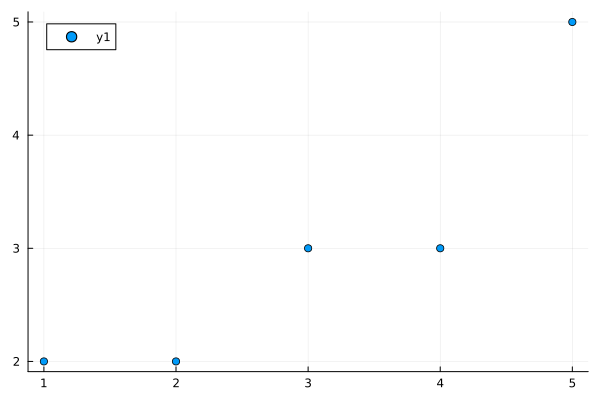

In [30]:
scatter(1:1:5, [2,2,3,3,5])

## Bonus

Ciekawe zastosowanie znajomości IEEE-754 do obliczania odwrotności pierwiastka, wykorzystane w grze Quake 3: [filmik](https://youtu.be/p8u_k2LIZyo)

# Zadania

### Zadanie 1

Porównać w języku Julia reprezentację bitową liczby 1/3 dla `Float16`, `Float32`, `Float64` oraz liczby, 
która jest inicjalizowana jako `Float16`, a potem rzutowana na `Float64`.

In [5]:
decode32(x::Float32) = (b=bitstring(x); (b[1], b[2:9], b[10:32]))
decode16(x::Float16) = (b=bitstring(x); (b[1], b[2:6], b[7:16]))
decode64(x::Float64) = (b=bitstring(x); (b[1], b[2:12], b[12:64]))

decode64 (generic function with 1 method)

In [8]:
println("Float 16: ", decode16(Float16(1/3)))
println("Float 32: ", decode32(Float32(1/3)))
println("Float 64: ", decode64(Float64(1/3)))

Float 16: ('0', "01101", "0101010101")
Float 32: ('0', "01111101", "01010101010101010101011")
Float 64: ('0', "01111111101", "10101010101010101010101010101010101010101010101010101")


### Zadanie 2

Zbadać, jak zmienia się odległość między kolejnymi liczbami zminnoprzecinkowymi 
reprezentowanymi w komputerze za pomocą języka Julia. 
Narysować wykres używając Plots zależności odległości od wartości liczby dla zakresu  od 1.0 do 1000000.0.

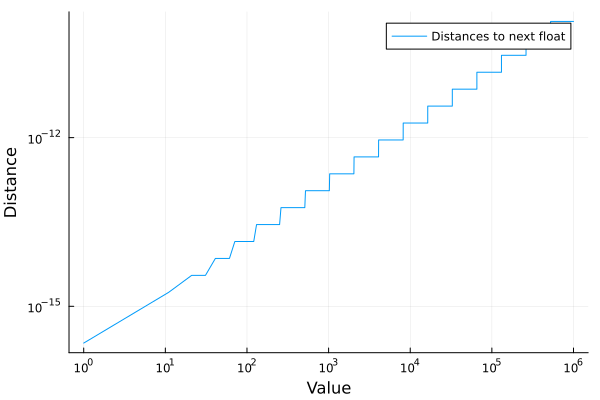

In [20]:
using Plots

values = collect(1.0: 10.0: 1000000.0)
distances = []
for i in values
    push!(distances, nextfloat(i) - i)
end

plot(values, distances, label="Distances to next float", xlabel="Value", ylabel="Distance", xscale=:log10, yscale=:log10)

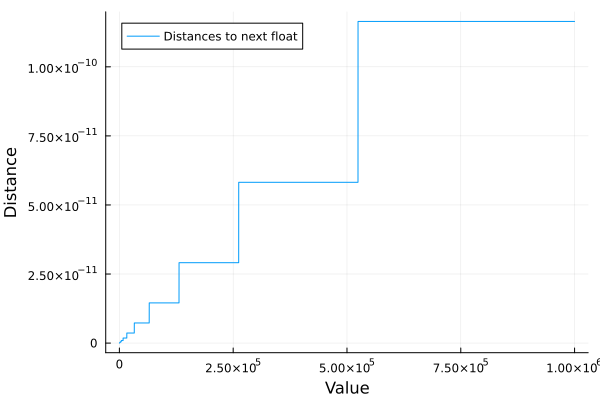

In [19]:
using Plots

values = collect(1.0: 100.0: 1000000.0)
distances = []
for i in values
    push!(distances, nextfloat(i) - i)
end

plot(values, distances, label="Distances to next float", xlabel="Value", ylabel="Distance")

### Zadanie 3

Jedną z bibliotek numerycznych, jaką dodatkowo będziemy używać na zajęciach jest <a href="http://www.gnu.org/software/gsl/gsl.html">GSL</a> (język C). Opis <a href="https://www.gnu.org/software/gsl/doc/html/usage.html"> jak używać </a>. Korzystając ze <a href="https://www.gnu.org/software/gsl/doc/html/ieee754.html"> wsparcia dla wyświetlania reprezentacji liczb zmiennoprzecinkowych</a> zobaczyć jak zmienia się cecha i mantysa dla coraz mniejszych liczb. Zaobserwować, kiedy matysa przestaje być znormalizowana i dlaczego?

Kod załączyć jako komórka Markdown sformatowana jako C ([link](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#code)). Wynik także jako Markdown (kod albo fragment zrzutu ekranu).

```c

#include <stdio.h>
#include <gsl/gsl_ieee_utils.h>

int main(){
    double x = 1.0;
    for (int i = 0; i < 100; i++)
    {
        gsl_ieee_printf_double(&x);
        printf("\n");
        x /= 1.4;
    }
    return 0;
}

 1.0000000000000000000000000000000000000000000000000000*2^0
 1.0101110110000110011111000011111011001110001010100101*2^-11
 1.1101110100110111111101010110100110001100001011000010*2^-22
 1.0100010111000111111111100011101111000100000010110000*2^-32
 1.1011110011001100110010100110001101011001011111001111*2^-43
 1.0010111110100110011011010111110111011001011010111101*2^-53
 1.1001111010010101011001111100000011111101001010010110*2^-64
 1.0001101100000101101111001110111000111110001110111010*2^-74
 1.1000001001101011100000001110110111100110011000000111*2^-85
 1.0000011111001011110001110100101001010111101000110111*2^-95
 1.0110100000101011011000110110001000010110101101111001*2^-106
 1.1110101111000000010111000000000000011111000001000011*2^-117
 1.0100111110110011110010010110001100010001110000101011*2^-127
 1.1100101001011000011101001001010011101010100000101010*2^-138
 1.0011100011100101101011111101011110101010010101010001*2^-148
 1.1010101100110101100000001100111100010010111000101100*2^-159
 1.0010001110100100001011101111100100111001010001000010*2^-169
 1.1000111000110000000010011000010101101100111010000100*2^-180
 1.0000111111010100010101011011000001101011000111011000*2^-190
 1.0111001100100011010001011110001111100110001101110101*2^-201
 1.1111101010111010000011101101111001101001011011010000*2^-212
 1.0101100111101100111011001100101110110111001111101101*2^-222
 1.1101100001001101101110001011100101001100000111000111*2^-233
 1.0100001001101101000010010101111001101001001101001110*2^-243
 1.1011100000111000000001110101010010000111011100110011*2^-254
 1.0010110010000101110100100111110010011011010001011100*2^-264
 1.1001101001010000010011111101101010011001010010100001*2^-275
 1.0001100000011011100001010000010100101111111110111111*2^-285
 1.0111111001110000101010101011000110111111110011101100*2^-296
 1.0000010100010100010000001010010100001000101111100101*2^-306
 1.0110010001110101110000110111000010101111110001110001*2^-317
 1.1110011010101111110011100001010101101010111000000000*2^-328
 1.0100110000111110101011000001011011010000001000001100*2^-338
 1.1100010110011111111110101010100100001011110001111011*2^-349
 1.0011010110101100101100110100111100111000100000101110*2^-359
 1.1010011011001111000111110010010001111011100100111111*2^-370
 1.0010000010100011001111011000100110001011101010001001*2^-380
 1.1000101000010110001011000110110010011011001011101000*2^-391
 1.0000110100000111101000001011011101011110010101010000*2^-401
 1.0110111101010000101110101010100111001101111011111010*2^-412
 1.1111010110000010000001010000000001101010011010001010*2^-423
 1.0101011001011100110110110010001100011001100010011010*2^-433
 1.1101001101110000011100011000001010000110100010010110*2^-444
 1.0011111100011010111011010011101111000000001100100001*2^-454
 1.1011001110101111010110000110000111110110101101011011*2^-465
 1.0010100101101101011101100101110011010001011000010111*2^-475
 1.1001011000010110011110100000001001111011011001100101*2^-486
 1.0001010100111000111111001001011111100001100011011000*2^-496
 1.0111101010000000010100101011101011100011011001100110*2^-507
 1.0000001001100011111000111101001110001100111001110000*2^-517
 1.0110000011001001111010110100100001101110011101010111*2^-528
 1.1110000110101100100110101010101101000001011110101101*2^-539
 1.0100100011010010101011000111110100011010010001001101*2^-549
 1.1100000011110011111100110000001110001101101011011101*2^-560
 1.0011001001111100001101011111000010101101001011011010*2^-570
 1.1010001001110100010101110100110010110011000110100010*2^-581
 1.0001110110101010001101111000000000100010111000101100*2^-591
 1.1000011000000111000111110110011101000100110010110001*2^-602
 1.0000101001000010010011010110101010101101111100000101*2^-612
 1.0110101110001000010000110111100001100100111100110111*2^-623
 1.1111000001010111101111011011110110100011000101110010*2^-634
 1.0101001011010110001011100011111010001110101111010011*2^-644
 1.1100111010011111111111011001101001011100011111001000*2^-655
 1.0011101111010001100100101000000010010110100001001100*2^-665
 1.1010111100110010100111011011001011111010100100000110*2^-676
 1.0010011001011101010000110110000011101100100101100111*2^-686
 1.1001000111100111110010001000100111001011100011011111*2^-697
 1.0001001001011110000011110110001011011000110010001011*2^-707
 1.0111011010011010010111010101111010101110011101111100*2^-718
 1.1111111101110101001110111110010110011111101100110011*2^-729
 1.0101110100100111110000010001111111010100000110101100*2^-739
 1.1101110010110110100111101000110001100101001011010110*2^-750
 1.0100010101101111101100101000110011100110001011100000*2^-760
 1.1011110001010100001111001101001101111101001011000110*2^-771
 1.0010111101010100001000010101010011111100000001011011*2^-781
 1.1001111000100101000010101011000101111000110111001100*2^-792
 1.0001101010111001000001111111101110001011001010111000*2^-802
 1.1000001000000010110001011111001100010110110000101001*2^-813
 1.0000011110000100010010000101010000000111010110000111*2^-823
 1.0110011111001001110001011011110100100011010010011010*2^-834
 1.1110101100111011000101001100111001011010100000010011*2^-845
 1.0100111101011000110011010101100110101011101100011010*2^-855
 1.1100100111011100001110110011000000000101000010110001*2^-866
 1.0011100010010000111000100001011100111001010111111010*2^-876
 1.1010101011000001101101111100001011011101101100011011*2^-887
 1.0010001101010101001001000000010010101111111010110101*2^-897
 1.1000110111000100000111100000111111110100111101111001*2^-908
 1.0000111110001010101010010101100000001000110110100010*2^-918
 1.0111001010111110101011110011101101110000011100000010*2^-929
 1.1111101000110000101110001010001100010011000001111011*2^-940
 1.0101100110001111001010110111000101011111100110000000*2^-950
 1.1101011111001101101101101110000001101100101011000001*2^-961
 1.0100001000010101101001100111110010001000111111100000*2^-971
 1.1011011111000000101101111001111001101101001101110101*2^-982
 1.0010110000110100010111110101000000101001110010100101*2^-992
 1.1001100111100001000110110000110100110001100011000110*2^-1003
 1.0001011111001111100110100101000101011110100101010001*2^-1013
 0.0101111110000010010000001111011000111010001110011011*2^-1022
 0.0000000000010000010011001101011111100011000001101000*2^-1022
 0.0000000000000000000000101100100000101010010011100101*2^-1022


### Zadanie 4

Na przykładzie wybranego algorytmu niestabilnego numerycznie: 
1. Pokazać, że działa źle.
2. Pokazać które konkretnie działania powodują zwiększenie błędu (np. dzielenie przez małą liczbę, cancellation).
3. Zademonstować wersję stabilną.

Wszystkie punkty przedstawić w postaci notatnika Julii.

In [1]:
# Czy punkty leżą na linii?

function generate_linear_points(n=5000, A=2, B=1)
    x = randn(n) * 1e-15
    y = A .* x .+ B
    return x, y
end

function point_on_line(x, y, A, B)
    x1, y1 = 0.0, B 
    x2, y2 = 1.0, A + B
    det = (x1 * y2 + x2 * y + x * y1) - (y1 * x2 + y2 * x + y * x1)
    return det == 0
end

function point_on_line_eps(x, y, A, B, eps=10e-6)
    x1, y1 = 0.0, B 
    x2, y2 = 1.0, A + B
    det = (x1 * y2 + x2 * y + x * y1) - (y1 * x2 + y2 * x + y * x1)
    return abs(det) < eps
end

X, Y = generate_linear_points()
unstable_results = point_on_line.(X, Y, 2, 1)
stable_results = point_on_line_eps.(X,Y,2,1, 10e-2)
println("Niestabilna metoda: ", sum(unstable_results), " / ", length(Y))
println("Stabilna metoda: ", sum(stable_results), " / ", length(Y))

Niestabilna metoda: 4200 / 5000
Stabilna metoda: 5000 / 5000
